## 6.2

**Developing a model to predict permeability (see Sect. 1.4) could save significant resources for a pharmaceutical company, while at the same time more rapidly identifying molecules that have a sufficient permeability to become a drug:**

**(a) Load the data.**

**(b) The fingerprint predictors indicate the presence or absence of substructures of a molecule and are often sparse meaning that relatively few of the molecules contain each substructure. Filter out the predictors that have low frequencies using the nearZeroVar function from the caret package.**

**How many predictors are left for modeling?**

Freq Predictors\
0     38\
1    296\
2    151\
3     59\
4     51\
5     48\
6     30\
7     21\
8     25\
9     19\
Over 485 predictors have fewer than 3 active flags, these predictors are removed.

**(c) Split the data into a training and a test set, pre-process the data, and tune a PLS model. How many latent variables are optimal and what is the corresponding resampled estimate of R2?**

Fitting PLS on the training and evaluating on the validation set, 2 latent variables are optimal and have a R2 of 0.55 

**(d) Predict the response for the test set. What is the test set estimate of R2?**

0.53

**(e) Try building other models discussed in this chapter. Do any have better predictive performance?**

**(f) Would you recommend any of your models to replace the permeability
laboratory experiment?**

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from scipy.stats import boxcox

from linearmodels import pca, penalised_regression

In [3]:
fingerprints = pd.read_csv("data/fingerprints.csv", index_col="ID", header=0)
permeability = pd.read_csv("data/permeability.csv", index_col="ID", header=0)

data = pd.concat([fingerprints, permeability], axis="columns")

In [4]:
n_zeros = (fingerprints == 0).sum(axis="rows")

In [5]:
aa = n_zeros.apply(lambda x:x if x < 83 else 165-x)

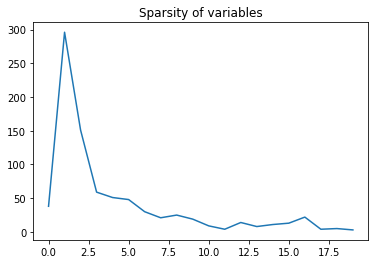

In [6]:
plt.plot(aa.value_counts().sort_index(ascending=True)[:20])
plt.title("Sparsity of variables")
plt.show()

In [7]:
min_freq = 3
max_freq = len(data)-min_freq
sparse_vars = list(n_zeros[(n_zeros<min_freq)|(n_zeros>max_freq)].index)
non_sparse = data.drop(columns=sparse_vars)

In [8]:
w_sparse={}
n_sparse={}
y={}

# Setting indexes
train_val, test = train_test_split(data, shuffle=True, test_size=0.2)
train, val = train_test_split(train_val, shuffle=True, test_size=0.25)
train, val, train_val, test = train.index, val.index, train_val.index, test.index

# Using indexes to seperate datasets
w_ = data.drop(columns=["permeability"])
w_sparse["train"] = w_.loc[train, :]
w_sparse["val"] = w_.loc[val, :]
w_sparse["train_val"] = w_.loc[train_val, :]
w_sparse["test"] = w_.loc[test, :]

n_ = data.drop(columns=["permeability"] + sparse_vars)
n_sparse["train"] = n_.loc[train, :]
n_sparse["val"] = n_.loc[val, :]
n_sparse["train_val"] = n_.loc[train_val, :]
n_sparse["test"] = n_.loc[test, :]

y_ = data["permeability"]
y["train"] = y_.loc[train]
y["val"] = y_.loc[val]
y["train_val"] = y_.loc[train_val]
y["test"] = y_.loc[test]

In [9]:
pls_scores = []
for i in range(1, 51): #len(w_sparse["train"])):
    pls = PLSRegression(n_components=i)
    pls.fit(X=w_sparse["train"], Y=y["train"])
    pls_scores.append(pls.score(X=w_sparse["val"], y=y["val"]))

In [10]:
pls_scores_n = []
for i in range(1, 51): #len(n_sparse["train"])):
    pls = PLSRegression(n_components=i)
    pls.fit(X=n_sparse["train"], Y=y["train"])
    pls_scores_n.append(pls.score(X=n_sparse["val"], y=y["val"]))

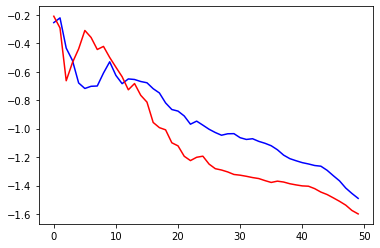

In [11]:
plt.plot(pls_scores[:50], c="b")
plt.plot(pls_scores_n[:50], c="r")
plt.show()

In [12]:
ds = {}
for k in n_sparse:
    ds["x_"+k] = n_sparse[k]
    ds["y_"+k] = y[k]



In [14]:
pca(ds)

0.5976390278986853

In [78]:
ols = linear_model.LinearRegression()
ols.fit(n_sparse["train"], y["train"])
ols.score(n_sparse["val"], y["val"])

-4.58927021188396e+21

In [15]:
def ols(ds):
    ols = linear_model.LinearRegression()
    ols.fit(X=ds["x_train_val"], y=ds["y_train_val"])
    return ols.score(X=ds["x_test"], y=ds["y_test"])

In [20]:
def pls(ds, boxcox=False, max_components=None):
    """
    Applies partial least squares to find R2 of test dataset.
    
    This function uses the train/val split to find the best number of components. It then fits a model on train_val using best number of components to predict the test dataset. Finally it returns the R2 of the test dataset.
    
    Parameters:
        arg1 (dict): dictionary of pd.DataFrames. Should contain {
            "x_train": predictor values of training set,
            "x_val": predictor values of validation set,
            "x_train_val": predictor values of training and validation sets,
            "x_test": predictor values of testing set,
            "y_train": target values of training set,
            "y_val": target values of validation set,
            "y_train_val": target values of training and validation sets,
            "y_test": target values of testing set
        }
        arg2 (bool): whether Box Cox transformation is to be applied to predictor variables.
        arg3 (int): maximum number of components used in pca
    
    Returns:
        float: R2 value from applying the model trained train_val on test.
    """
    pls_scores = []

    if boxcox:
        ds_bc = {}
        ds_bc["x_train"], lambdas = boxcox_transform(ds["x_train"])
        ds_bc["x_val"], _ = boxcox_transform(ds["x_val"], lambdas=lambdas)
        ds_bc["x_train_val"], lambdas = boxcox_transform(ds["x_train_val"])
        ds_bc["x_test"], _ = boxcox_transform(ds["x_test"], lambdas=lambdas)
    else:
        ds_bc = ds
    
    if max_components is None: max_components=min(ds_bc["x_train"].shape)-1
    for n_components in range(1, max_components):
        pls = PLSRegression(n_components=n_components)
        pls_x = {}
        pls.fit(ds_bc["x_train"], ds["y_train"])
        pls_scores.append(pls.score(X=ds_bc["x_val"], y=ds["y_val"]))

    # Select number of components with highest R2 score
    # Fit regression on training and validation set
    # Score on test set
    n = pls_scores.index(max(pls_scores))+1
    pls_final = PLSRegression(n_components=n)
    pls_final.fit(ds_bc["x_train_val"], ds["y_train_val"])
    return pls_final.score(X=ds_bc["x_test"], y=ds["y_test"])

In [23]:
trials = 100
results = pd.DataFrame()

for i in range(trials):
    # Setting indexes
    train_val, test = train_test_split(data, shuffle=True, test_size=0.2)
    train, val = train_test_split(train_val, shuffle=True, test_size=0.2)
    ds = {}
    ds["x_train"] = train.drop(columns=["permeability"]+sparse_vars)
    ds["x_val"] = val.drop(columns=["permeability"]+sparse_vars)
    ds["x_train_val"] = train_val.drop(columns=["permeability"]+sparse_vars)
    ds["x_test"] = test.drop(columns=["permeability"]+sparse_vars)
    ds["y_train"] = train["permeability"]
    ds["y_val"] = val["permeability"]
    ds["y_train_val"] = train_val["permeability"]
    ds["y_test"] = test["permeability"]

    results = results.append({
        "ols":ols(ds),
        "pca": pca(ds, max_components=40),
        "pls": pls(ds, max_components=40),
        "l1": penalised_regression(ds, linear_model.Lasso),
        "l2": penalised_regression(ds, linear_model.Ridge)
    }, ignore_index=True)
    print(i)

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189.2374731099058, tolerance: 2.8850413380357143
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189.24138242761884, tolerance: 2.8850413380357143
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189.32256261863057, tolerance: 2.8850413380357143
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

0


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105.32810025434551, tolerance: 2.3064346660357145
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105.33410299813795, tolerance: 2.3064346660357145
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107.5101174795161, tolerance: 2.3064346660357145
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

1


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5973197053287747, tolerance: 2.8616174697261907
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.555299760653999, tolerance: 2.8616174697261907
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.3678440461569, tolerance: 2.8616174697261907
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

2


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71.97719184716267, tolerance: 2.544708659619048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71.98082308210131, tolerance: 2.544708659619048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71.98726602063955, tolerance: 2.544708659619048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

3


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 172.51308599430462, tolerance: 2.4836323087261905
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 172.51919645207505, tolerance: 2.4836323087261905
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 172.53004968325683, tolerance: 2.4836323087261905
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate

4


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.82275790107049, tolerance: 2.6229235833690474
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.814441325287504, tolerance: 2.6229235833690474
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.79968883342873, tolerance: 2.6229235833690474
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

5


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.902329931348554, tolerance: 2.4508250678214285
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.4527299814945, tolerance: 2.4508250678214285
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.4653966760067, tolerance: 2.4508250678214285
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

6


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 157.9269176328111, tolerance: 2.1514708097261903
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 157.93081752488013, tolerance: 2.1514708097261903
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 157.94281069097485, tolerance: 2.1514708097261903
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

7


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.06483256447842, tolerance: 2.5778688234761904
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.06965357370364, tolerance: 2.5778688234761904
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.07820895455776, tolerance: 2.5778688234761904
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

8


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.42302185076407, tolerance: 2.6384881918690475
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.42730274790154, tolerance: 2.6384881918690475
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.43489631084412, tolerance: 2.6384881918690475
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

9


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177.4520580995057, tolerance: 2.3987229100357146
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177.4560288064547, tolerance: 2.3987229100357146
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177.46307514051452, tolerance: 2.3987229100357146
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

10


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.756303602865156, tolerance: 2.550371716035714
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.761837945684313, tolerance: 2.550371716035714
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.771663659153155, tolerance: 2.550371716035714
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

11


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 197.66182181534694, tolerance: 2.4109898840714283
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 198.49161982982488, tolerance: 2.4109898840714283
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 198.5088826623835, tolerance: 2.4109898840714283
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

12


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.74259601245655, tolerance: 2.49821620622619
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.75013776751045, tolerance: 2.49821620622619
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.72903251161577, tolerance: 2.49821620622619
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.

13


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 154.5761554482175, tolerance: 2.6455644411547614
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 154.58223532662933, tolerance: 2.6455644411547614
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 154.5930359960649, tolerance: 2.6455644411547614
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

14


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 140.46862169747862, tolerance: 2.5342709065714284
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 140.47264996872093, tolerance: 2.5342709065714284
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 140.41139836498547, tolerance: 2.5342709065714284
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate

15


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80.18586104962084, tolerance: 2.737164751821429
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75.07967505872847, tolerance: 2.737164751821429
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75.08700456507788, tolerance: 2.737164751821429
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

16


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.554692222704865, tolerance: 2.705106900035714
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.55970057880807, tolerance: 2.705106900035714
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.555407121301727, tolerance: 2.705106900035714
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

17


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 154.28294943881787, tolerance: 2.3290039811547616
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 154.28898657312772, tolerance: 2.3290039811547616
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 154.29970477746787, tolerance: 2.3290039811547616
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate

18


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56.27224927530209, tolerance: 2.5218304455714287
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56.275824269105684, tolerance: 2.5218304455714287
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.996403044291526, tolerance: 2.5218304455714287
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

19


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 124.99224509453981, tolerance: 2.472284803535714
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122.18837101678268, tolerance: 2.472284803535714
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117.42461226783423, tolerance: 2.472284803535714
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

20


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 98.4824136171921, tolerance: 2.453124789083333
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 98.04262037929473, tolerance: 2.453124789083333
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 98.96535459284645, tolerance: 2.453124789083333
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

21


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105.82249190855111, tolerance: 2.369752942654762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105.0528206567822, tolerance: 2.369752942654762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105.05957649612824, tolerance: 2.369752942654762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

22


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78.24995099587792, tolerance: 2.6505893187261904
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.63206403411782, tolerance: 2.6505893187261904
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.62573053213255, tolerance: 2.6505893187261904
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

23


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 247.09311263092783, tolerance: 2.7236356078928576
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 247.09776711505634, tolerance: 2.7236356078928576
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 247.10602872470787, tolerance: 2.7236356078928576
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate

24


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 159.9704435889485, tolerance: 2.3170965621428574
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 159.9745376164746, tolerance: 2.3170965621428574
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 162.56772878936277, tolerance: 2.3170965621428574
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

25


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80.70319144608469, tolerance: 2.83102462472619
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80.70798733057339, tolerance: 2.83102462472619
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80.71649739883303, tolerance: 2.83102462472619
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.

26


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117.14290433279359, tolerance: 2.2299441641428572
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117.14740324411595, tolerance: 2.2299441641428572
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117.15556288050044, tolerance: 2.2299441641428572
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate

27


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 190.56575676187364, tolerance: 2.208959661226191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 190.57286530352826, tolerance: 2.208959661226191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 190.58548678980324, tolerance: 2.208959661226191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

28


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.99456171884912, tolerance: 2.386288425333333
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.99881226353336, tolerance: 2.386288425333333
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.80091215718768, tolerance: 2.386288425333333
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

29


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.28984417835903, tolerance: 2.480588267619048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.29303655999853, tolerance: 2.480588267619048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.29869501710402, tolerance: 2.480588267619048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

30


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.53290829996251, tolerance: 2.509219667642857
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.538713396185138, tolerance: 2.509219667642857
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.549020145824848, tolerance: 2.509219667642857
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

31


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.31929908065806, tolerance: 2.339242740892857
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.31049042236873, tolerance: 2.339242740892857
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.31751519387657, tolerance: 2.339242740892857
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

32


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.518098671692158, tolerance: 2.376404452404762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.523365110898123, tolerance: 2.376404452404762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.532715001074997, tolerance: 2.376404452404762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

33


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 153.21874343354477, tolerance: 2.233174340571429
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 153.26628158004752, tolerance: 2.233174340571429
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 153.27241491369142, tolerance: 2.233174340571429
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

34


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67.61178024556827, tolerance: 2.797223835619048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67.62472683209975, tolerance: 2.797223835619048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67.4675487346465, tolerance: 2.797223835619048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

35


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.62327038995348, tolerance: 2.8462819661547623
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.628541496190486, tolerance: 2.8462819661547623
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.637897477483655, tolerance: 2.8462819661547623
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

36


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127.55365161531697, tolerance: 2.929920533654762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127.55765741207018, tolerance: 2.929920533654762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127.5647597997973, tolerance: 2.929920533654762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

37


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.40259705015249, tolerance: 2.8602090363928574
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.410411389717134, tolerance: 2.8602090363928574
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.424328182692819, tolerance: 2.8602090363928574
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

38


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189.76284502789906, tolerance: 2.9764889651547626
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189.7683154559295, tolerance: 2.9764889651547626
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189.88932010987355, tolerance: 2.9764889651547626
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

39


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 430.2160664289649, tolerance: 2.6835356697261905
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 430.2198058629471, tolerance: 2.6835356697261905
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 430.22643932986534, tolerance: 2.6835356697261905
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

40


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.3320796140575, tolerance: 2.4877937697261907
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.05175597877001, tolerance: 2.4877937697261907
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.05851373805763, tolerance: 2.4877937697261907
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

41


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 233.14304791853792, tolerance: 2.0079166303214286
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 233.14809281872374, tolerance: 2.0079166303214286
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 236.1025013488204, tolerance: 2.0079166303214286
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

42


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 103.98502710511858, tolerance: 2.5671352576547615
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 103.01721182330819, tolerance: 2.5671352576547615
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102.4698805394981, tolerance: 2.5671352576547615
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

43


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91.08440809165435, tolerance: 2.297692072833333
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91.08763364925076, tolerance: 2.297692072833333
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89.97862166698289, tolerance: 2.297692072833333
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

44


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 203.9746444532405, tolerance: 2.721736166869048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 203.979500603373, tolerance: 2.721736166869048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 203.988119411039, tolerance: 2.721736166869048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent

45


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 97.07973389824267, tolerance: 2.5020309087261903
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 97.08376138460245, tolerance: 2.5020309087261903
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 97.09090438343068, tolerance: 2.5020309087261903
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

46


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.451033166719824, tolerance: 2.7841315455000006
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.3419505585145, tolerance: 2.7841315455000006
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.349921958384975, tolerance: 2.7841315455000006
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

47


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161.30974844880828, tolerance: 2.6995107775357137
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161.3142801726383, tolerance: 2.6995107775357137
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161.3223211058046, tolerance: 2.6995107775357137
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

48


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161.04815468433884, tolerance: 2.779291564904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161.0535336956262, tolerance: 2.779291564904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161.06316743888215, tolerance: 2.779291564904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

49


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 250.44723002100048, tolerance: 2.478008456404762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 250.4506169023911, tolerance: 2.478008456404762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 257.12147469054116, tolerance: 2.478008456404762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

50


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 278.15829507242285, tolerance: 2.405966515571429
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277.78361214692217, tolerance: 2.405966515571429
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277.5771106215005, tolerance: 2.405966515571429
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

51


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.45276559362626, tolerance: 2.396978521392857
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.45851708761873, tolerance: 2.396978521392857
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.46883037420455, tolerance: 2.396978521392857
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

52


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 101.46250488090313, tolerance: 2.616405447654762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 101.46921738354743, tolerance: 2.616405447654762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 101.48477498278986, tolerance: 2.616405447654762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

53


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.107676544955016, tolerance: 2.5671305256547625
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.031788683617698, tolerance: 2.5671305256547625
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.001131641523237, tolerance: 2.5671305256547625
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate

54


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 85.39350806505706, tolerance: 2.6655208506190475
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 85.39739655036536, tolerance: 2.6655208506190475
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 85.40429273225412, tolerance: 2.6655208506190475
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

55


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226.09562791962182, tolerance: 2.422522794904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226.65295515571827, tolerance: 2.422522794904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226.64986505396988, tolerance: 2.422522794904762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

56


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 215.08330847786874, tolerance: 2.528596192892857
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 215.08451473727928, tolerance: 2.528596192892857
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 215.09149020537853, tolerance: 2.528596192892857
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

57


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 176.5215043165931, tolerance: 2.67821556175
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177.96092912953156, tolerance: 2.67821556175
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177.96749459655618, tolerance: 2.67821556175
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530:

58


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 134.25003953836375, tolerance: 2.589897049321429
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 134.2549464033805, tolerance: 2.589897049321429
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133.92238285384002, tolerance: 2.589897049321429
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

59


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 193.5947559267898, tolerance: 2.279159827119048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 193.59843907108188, tolerance: 2.279159827119048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 192.29226720873274, tolerance: 2.279159827119048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

60


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137.9319166166449, tolerance: 2.177634659404762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132.63320786762716, tolerance: 2.177634659404762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 130.8246245796234, tolerance: 2.177634659404762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desc

61


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.83922468552585, tolerance: 2.5545105376428574
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.84403308623174, tolerance: 2.5545105376428574
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.85258666232399, tolerance: 2.5545105376428574
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

62


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 169.5953729770417, tolerance: 2.495849395154762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 169.59987626107784, tolerance: 2.495849395154762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 169.60786794517446, tolerance: 2.495849395154762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

63


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.654455419105258, tolerance: 2.5362863524761905
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.658174561565904, tolerance: 2.5362863524761905
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.66477151439328, tolerance: 2.5362863524761905
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

64


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.13015308981681, tolerance: 2.817436472404762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.89747664757723, tolerance: 2.817436472404762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.982109089898856, tolerance: 2.817436472404762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desc

65


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 270.1955909217661, tolerance: 2.348887031869048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 270.1930101888105, tolerance: 2.348887031869048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 270.19937309086083, tolerance: 2.348887031869048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desc

66


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108.24245028981119, tolerance: 2.8787595569047624
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108.24672948701028, tolerance: 2.8787595569047624
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108.6971239820993, tolerance: 2.8787595569047624
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

67


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 255.2142793406461, tolerance: 2.6681226950833334
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 255.21842016171905, tolerance: 2.6681226950833334
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 302.07547272043024, tolerance: 2.6681226950833334
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

68


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.958673771484296, tolerance: 2.163634541404762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.963447446054168, tolerance: 2.163634541404762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.330649540782957, tolerance: 2.163634541404762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

69


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92.8911006101072, tolerance: 2.6024712036547615
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92.89624111436893, tolerance: 2.6024712036547615
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92.02527552334699, tolerance: 2.6024712036547615
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

70


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 72.49306517835157, tolerance: 2.79532486825
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71.75369297617978, tolerance: 2.79532486825
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71.7468137585394, tolerance: 2.79532486825
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Co

71


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 250.44318094152953, tolerance: 2.771615337083333
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 251.05657617405583, tolerance: 2.771615337083333
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 257.90994758486914, tolerance: 2.771615337083333
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

72


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 72.12763255536103, tolerance: 2.134532288892857
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71.51032265274657, tolerance: 2.134532288892857
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71.4608679980335, tolerance: 2.134532288892857
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

73


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 303.4523636900554, tolerance: 2.23883573675
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 303.4555435020553, tolerance: 2.23883573675
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 303.4611805188339, tolerance: 2.23883573675
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: C

74


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.973410105347288, tolerance: 2.5008632605
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.924825767783123, tolerance: 2.5008632605
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.838239771416283, tolerance: 2.5008632605
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: C

75


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135.39681610919857, tolerance: 2.355592924369048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 134.97341217939078, tolerance: 2.355592924369048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 134.9820405578589, tolerance: 2.355592924369048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

76


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122.64841721494324, tolerance: 2.276119992
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122.65530889883084, tolerance: 2.276119992
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122.66980633986047, tolerance: 2.276119992
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: Conv

77


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.86036049363146, tolerance: 2.5936255035357143
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.066866100375051, tolerance: 2.5936255035357143
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.14195221966776, tolerance: 2.5936255035357143
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

78


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109.85745743177478, tolerance: 2.489674792119048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109.86037858333682, tolerance: 2.489674792119048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109.86555969317926, tolerance: 2.489674792119048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

79


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.74021157292628, tolerance: 2.4874587883333334
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.40962069229389, tolerance: 2.4874587883333334
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.46464392639509, tolerance: 2.4874587883333334
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

80


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.16820974196931, tolerance: 2.255934946404762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.30247778719627, tolerance: 2.255934946404762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.69471327114892, tolerance: 2.255934946404762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

81


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 130.35619045713077, tolerance: 2.503940683119048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 130.3598192947403, tolerance: 2.503940683119048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 124.5830805874065, tolerance: 2.503940683119048
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desc

82


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 140.206887027025, tolerance: 2.5628407174761905
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136.3210688600813, tolerance: 2.5628407174761905
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 134.98650145958283, tolerance: 2.5628407174761905
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

83


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102.49415708711149, tolerance: 2.8867182976190473
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102.49792468430186, tolerance: 2.8867182976190473
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102.58450802043197, tolerance: 2.8867182976190473
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate

84


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 143.4171443415384, tolerance: 2.392329151226191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 143.91728601150896, tolerance: 2.392329151226191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 143.9240242260032, tolerance: 2.392329151226191
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desc

85


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121.86018464462569, tolerance: 2.3616488058690477
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121.86390290199257, tolerance: 2.3616488058690477
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120.60565217839383, tolerance: 2.3616488058690477
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate

86


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.54346245325796, tolerance: 2.391360981285714
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.54685741026921, tolerance: 2.391360981285714
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 97.42269616305472, tolerance: 2.391360981285714
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

87


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81.56236471220096, tolerance: 2.5933470625357145
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81.5687981369438, tolerance: 2.5933470625357145
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81.75740793058733, tolerance: 2.5933470625357145
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

88


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.62923078497336, tolerance: 2.6628750291428576
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.711467664646506, tolerance: 2.6628750291428576
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.26453838061414, tolerance: 2.6628750291428576
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

89


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164.07588353894195, tolerance: 2.3610278088690473
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164.08487237818377, tolerance: 2.3610278088690473
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164.10084223793734, tolerance: 2.3610278088690473
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate

90


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.11034669701123, tolerance: 2.622763327404762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.115994198658882, tolerance: 2.622763327404762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.12602292497882, tolerance: 2.622763327404762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desc

91


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.452451078800662, tolerance: 2.1557540037857144
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.4378128902238005, tolerance: 2.1557540037857144
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.256989951399108, tolerance: 2.1557540037857144
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

92


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 197.5123916558552, tolerance: 2.6122038959761906
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 197.51712106462375, tolerance: 2.6122038959761906
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 198.42395806895894, tolerance: 2.6122038959761906
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

93


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 190.33425247317336, tolerance: 2.4384633343690476
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 190.3387380787268, tolerance: 2.4384633343690476
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 190.34628965443272, tolerance: 2.4384633343690476
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

94


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93.5210618082991, tolerance: 2.6942431436547616
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93.01264864990004, tolerance: 2.6942431436547616
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93.01888888604098, tolerance: 2.6942431436547616
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

95


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95.86606019114481, tolerance: 2.538884238654762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95.87181181021242, tolerance: 2.538884238654762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95.88202563138171, tolerance: 2.538884238654762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

96


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 166.69780952862, tolerance: 2.4397552765833335
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 166.69486252663057, tolerance: 2.4397552765833335
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 166.6896091609843, tolerance: 2.4397552765833335
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

97


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91.27045690996756, tolerance: 2.5202638893690477
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91.27464422957382, tolerance: 2.5202638893690477
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91.1124461755478, tolerance: 2.5202638893690477
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

98


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 166.29577647122812, tolerance: 2.4148223678333336
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 166.3019117253915, tolerance: 2.4148223678333336
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 166.31280071555787, tolerance: 2.4148223678333336
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

99


In [24]:
results.describe()

,ols,pca,pls,l1,l2
count,1.000000e+02,100.000000,100.000000,100.000000,100.000000
mean,-3.623922e+23,0.342352,0.285986,0.383268,0.186024
std,9.038942e+23,0.245723,0.301876,0.248547,0.302639
min,-5.672188e+24,-0.522045,-0.658734,-0.449826,-0.693152
25%,-2.307423e+23,0.223097,0.135146,0.342582,0.026845
50%,-2.521866e+22,0.392635,0.381298,0.439956,0.245167
75%,-9.718503e+20,0.495914,0.496953,0.534787,0.435597
max,-3.387595e+16,0.709113,0.788555,0.724640,0.629382
